# NFL Verse Analysis

In [80]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import nfl_data_py as nfl
import seaborn as sns

In [81]:
# Run only once to download the data then commment out.
# years = range(2010, 2024)

# # Get the play-by-play data
# pbp = nfl.import_pbp_data(years, downcast=True, cache=False, alt_path=None)

# # Schedule
# s = nfl.import_schedules(years)


In [82]:
# Run only once, then comment out the code below
# pbp.to_csv('../data/raw/NFL_verse_pbp_data.csv', index=False)
# s.to_csv('../data/raw/NFL_verse_schedules.csv', index=False)

Exploration of the datasets

In [ ]:
pbp = pd.read_csv('../data/raw/NFL_verse_pbp_data.csv' low_memory=False)
s = pd.read_csv('../data/raw/NFL_verse_schedules.csv')

/var/folders/fv/6ssdmf5n3cs0c8kp8swwnx280000gn/T/ipykernel_63667/1976117209.py:1: DtypeWarning: Columns (45,179,180,182,183,189,190,193,194,195,196,197,198,203,204,205,206,209,210,213,214,218,219,220,222,224,226,233,234,235,236,237,238,243,244,245,248,249,253,254,255,260,262,263,266,267,268,269,277,283,284,302,332,372,373,374,375,377,379,380,381,386,387,388,389) have mixed types. Specify dtype option on import or set low_memory=False.
  pbp = pd.read_csv('../data/raw/NFL_verse_pbp_data.csv')


Create an injury column from the box score description

In [84]:
pbp['Injury'] = pbp['desc'].str.contains('injur')

Select the data relevant to the analysis

In [85]:
pbp = pbp[['play_id','game_id','home_team','away_team','season_type','week','posteam',
'posteam_type','defteam','side_of_field','yardline_100','game_date',
'quarter_seconds_remaining','half_seconds_remaining','game_seconds_remaining',
'game_half','quarter_end','drive','sp','qtr','down','goal_to_go',
'time','yrdln','ydstogo','ydsnet','desc','play_type',
'yards_gained','shotgun','no_huddle','qb_dropback','qb_kneel','qb_spike','qb_scramble',
'pass_length','pass_location','air_yards','yards_after_catch','run_location',
'run_gap','field_goal_result','kick_distance','extra_point_result','two_point_conv_result','home_timeouts_remaining','away_timeouts_remaining','timeout',
'total_home_score','total_away_score','score_differential','Injury']]

Now we need to merge the dataframes to get the stats for each game such as weatger and field type

In [86]:
combined_data = pd.merge(pbp,s,on=['game_id','week','home_team','away_team'],how='left')

Surface has too many values, so we need to classify them into grass and turf

In [87]:
combined_data['surface'].value_counts()

surface
grass         316905
fieldturf     164853
sportturf      40400
matrixturf     29279
astroturf      17375
grass          16231
a_turf         15685
astroplay       1445
Name: count, dtype: int64

In [88]:
combined_data['surface'].replace('a_turf','fieldturf',inplace=True)
combined_data['surface'].replace('astroplay','fieldturf',inplace=True)
combined_data['surface'].replace('sportturf','fieldturf',inplace=True)
combined_data['surface'].replace('matrixturf','fieldturf',inplace=True)
combined_data['surface'].replace('astroturf','fieldturf',inplace=True)
combined_data['surface'].replace('grass ','grass',inplace=True)
combined_data['surface'].replace('dessograss','fieldturf',inplace=True)
combined_data['surface'].value_counts()

/var/folders/fv/6ssdmf5n3cs0c8kp8swwnx280000gn/T/ipykernel_63667/1820590482.py:1: FutureWarning: A value is trying to be set on a copy of a DataFrame or Series through chained assignment using an inplace method.
The behavior will change in pandas 3.0. This inplace method will never work because the intermediate object on which we are setting values always behaves as a copy.

For example, when doing 'df[col].method(value, inplace=True)', try using 'df.method({col: value}, inplace=True)' or df[col] = df[col].method(value) instead, to perform the operation inplace on the original object.


  combined_data['surface'].replace('a_turf','fieldturf',inplace=True)
/var/folders/fv/6ssdmf5n3cs0c8kp8swwnx280000gn/T/ipykernel_63667/1820590482.py:2: FutureWarning: A value is trying to be set on a copy of a DataFrame or Series through chained assignment using an inplace method.
The behavior will change in pandas 3.0. This inplace method will never work because the intermediate object on which we are 

surface
grass        333136
fieldturf    269037
Name: count, dtype: int64

In the box description we need to extract the severity of the injury

In [89]:
combined_data['Doubtful'] = combined_data['desc'].str.contains('Doubtful')
combined_data['Questionable'] = combined_data['desc'].str.contains('Questionable')
combined_data['Out'] = combined_data['desc'].str.contains('He is Out')

Now we can create a new column for the severity of the injury

In [90]:
conditions = [
  (combined_data['Injury'] == True) & (combined_data['Doubtful'] == True), # Doubtful
  (combined_data['Injury'] == True) & (combined_data['Questionable'] == True), # Questionable
  (combined_data['Injury'] == True) & (combined_data['Out'] == True), # Out
  (combined_data['Doubtful'] == False) & (combined_data['Questionable'] == False) & (combined_data['Out'] == False) & (combined_data['Injury'] == True), # Not Severe
  (combined_data['Injury'] == False) & (combined_data['Doubtful'] == False) & (combined_data['Questionable'] == False) & (combined_data['Out'] == False) # No Injury
]
severity = ['Doubtful', 'Questionable', 'Out','Not Severe', 'No Injury']

# Create a new column 'Severity' based on the conditions
combined_data['Severity'] = np.select(conditions, severity, default='No Injury')
combined_data['Severity'].value_counts()


Severity
No Injury       660766
Not Severe        7951
Questionable      2356
Out                798
Doubtful           201
Name: count, dtype: int64

In [91]:
len(combined_data)

672072

<Axes: xlabel='Severity'>

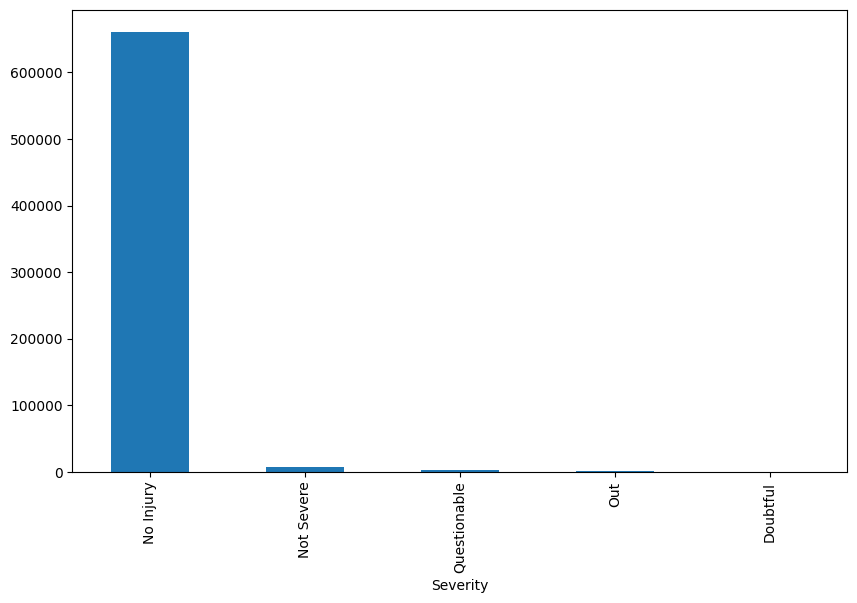

In [92]:
combined_data['Severity'].value_counts().plot(kind='bar', figsize=(10, 6))

Now we will begin selecting the data for analysis

In [93]:
training_data = combined_data[~combined_data['Severity'].isin(['No Injury'])]

In [108]:
y = training_data['Injury']


In [95]:
train_numeric = training_data[['week','qtr', 'down', 'ydstogo','yardline_100','spread_line',
                    'yards_gained', 'shotgun', 'no_huddle', 'qb_dropback',
                    'qb_scramble','season','overtime', 'div_game', 'wind', 'temp', 'score_differential']]

train_str = training_data[['game_half',
                    'play_type',
                    'pass_length','pass_location',
                    'run_location', 'run_gap','weekday','roof', 
                    'surface','stadium']]
pd.concat([train_numeric, train_str], axis=1).to_csv('../data/processed/NFL_verse_training_data.csv', index=False)

Endode the categorical variables and scale the numerical variables

In [96]:
from sklearn.calibration import LabelEncoder
from sklearn.preprocessing import StandardScaler
from sklearn.pipeline import make_pipeline
from sklearn.decomposition import PCA

pca = PCA()
le = LabelEncoder()
scaler = StandardScaler()
pipeline = make_pipeline(scaler, pca) 

for feat in train_str:
    train_str[feat] = le.fit_transform(train_str[feat].astype(str))

for feat in train_numeric:
    train_numeric[feat].fillna(train_numeric[feat].mean(), inplace=True)

/var/folders/fv/6ssdmf5n3cs0c8kp8swwnx280000gn/T/ipykernel_63667/3165086785.py:12: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  train_str[feat] = le.fit_transform(train_str[feat].astype(str))
/var/folders/fv/6ssdmf5n3cs0c8kp8swwnx280000gn/T/ipykernel_63667/3165086785.py:12: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  train_str[feat] = le.fit_transform(train_str[feat].astype(str))
/var/folders/fv/6ssdmf5n3cs0c8kp8swwnx280000gn/T/ipykernel_63667/3165086785.py:12: SettingWithCopyWarning: 
A value is trying 

In [97]:
X_enc = pipeline.fit_transform(pd.concat([train_numeric, train_str], axis=1))

In [ ]:
from sklearn.model_selection import train_test_split


X_train, X_test, y_train, y_test = train_test_split(X_enc, y, test_size=0.2, random_state=41)

In [99]:
df_processed = pd.DataFrame(
    data=X_enc, 
    index=pd.concat([train_numeric, train_str], axis=1).index, 
    columns=pd.concat([train_numeric, train_str], axis=1).columns
)

In [106]:
from sklearn.linear_model import LinearRegression


linr = LinearRegression()
linr.fit(X_train, y_train)

LinearRegression()

In [107]:
#See the R-Squared
from sklearn.metrics import precision_score, recall_score


score = linr.score(X_test, y_test)
print("R-squared: {:.2f}".format(score))

#Now test the model
y_pred = linr.predict(X_test)
print('Training Set:', linr.score(X_train,y_train))
print('Test Set:', linr.score(X_test,y_test))

# Calculate the accuracy, precision, and recall scores
print("Precision:", "{:.2f}%".format(precision_score(y_test, y_pred, average='macro')*100))
print("Recall:", "{:.2f}%".format(recall_score(y_test, y_pred, average='macro')*100))


R-squared: 1.00
Training Set: 1.0
Test Set: 1.0
Precision: 100.00%
Recall: 100.00%


Information gain

In [115]:
from sklearn.feature_selection import mutual_info_classif

combined_data = pd.concat([train_numeric, train_str], axis=1)
ig = mutual_info_classif(combined_data, y, random_state=42)
ig

array([8.84486114e-05, 2.65345834e-04, 6.63364585e-04, 6.19140279e-04,
       0.00000000e+00, 8.84486114e-05, 8.84486114e-05, 1.72474792e-03,
       1.32672917e-04, 1.45940209e-03, 0.00000000e+00, 3.09570140e-04,
       0.00000000e+00, 5.30691668e-04, 1.06138334e-03, 2.65345834e-04,
       1.32672917e-04, 7.07588891e-04, 1.06138334e-03, 6.63364585e-04,
       1.06138334e-03, 1.85742084e-03, 1.59207500e-03, 2.25543959e-03,
       1.59207500e-03, 6.63364585e-04, 8.84486114e-05])

In [116]:
# Create a dictionary to store the feature and its information gain
ig_dict = {}
for i in range(len(combined_data.columns)):
    ig_dict[combined_data.columns[i]] = ig[i]

In [118]:
ig_dict_sorted = dict(sorted(ig_dict.items(), key=lambda item: item[1], reverse=True))

# Select the top n features with the highest information gain
n = 10
selected_features = list(ig_dict_sorted.keys())[:n]

# Print the selected features
print('Selected Features:')
print(selected_features)

Selected Features:
['weekday', 'run_location', 'shotgun', 'run_gap', 'roof', 'qb_dropback', 'wind', 'play_type', 'pass_location', 'game_half']


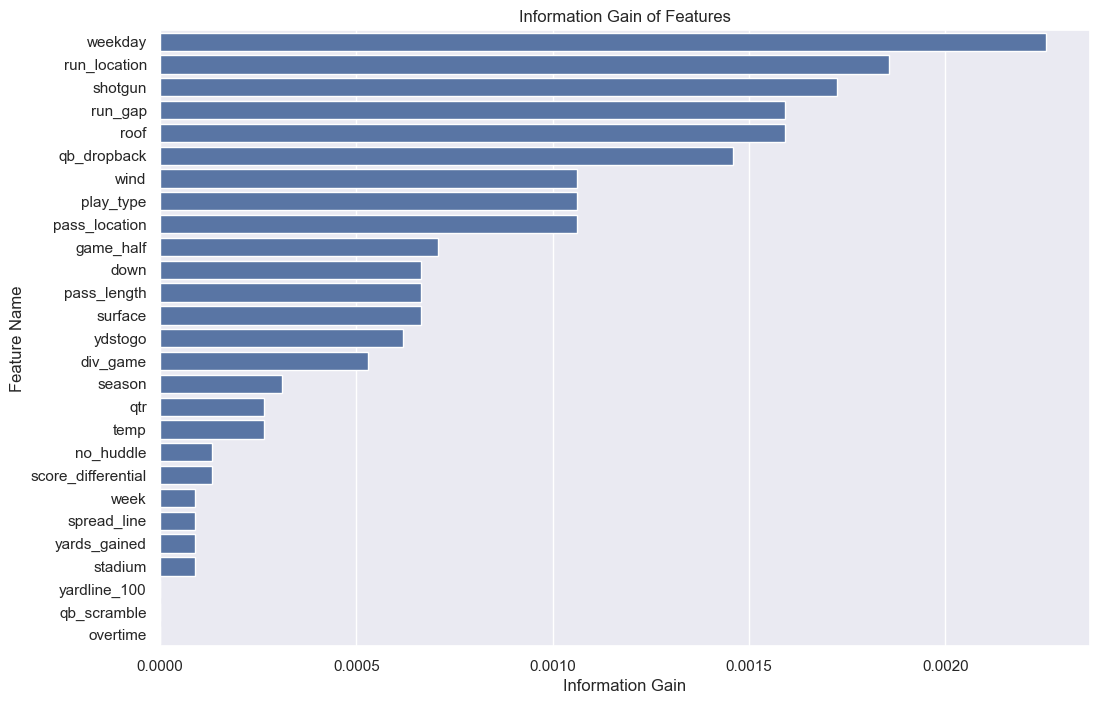

In [119]:
# Visualize the information gain of each feature
sns.set(style="whitegrid")
sns.set(rc={'figure.figsize':(12,8)})
sns.barplot(x=list(ig_dict_sorted.values()), y=list(ig_dict_sorted.keys()))
plt.title('Information Gain of Features')
plt.xlabel('Information Gain')
plt.ylabel('Feature Name')
plt.show()